In [1]:
%matplotlib inline
from os import listdir
from os.path import isfile, join
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
import statsmodels.stats.multitest as smt
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# 0. Load location and groupings information

In [31]:
## Read samples location info
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'dc_222_samples_info.tsv'
file_data = glob(dir_path + file_name)[0]
INFO = pd.read_csv(file_data, sep='\t')[['sample_ID', 'rookery-region', 'Year', 'group-Lkadj', 
                                         'Management units - based on DNA', 'Post_dupe_depth',
                                         'Exclude-all_GL_ROH_analyses', 'Sequencing_source-type']]
INFO.rename(columns={'sample_ID':'sample', 
                     'rookery-region':'rookery', 
                     'Year':'year',
                     'group-Lkadj': 'group',
                     'Management units - based on DNA': 'MU',
                     'Post_dupe_depth':'depth',
                     'Exclude-all_GL_ROH_analyses': 'exclude',
                     'Sequencing_source-type': 'batch'}, inplace=True)

# 1. Genome-wide heterozygosity

In [32]:
## Read summary file with total number of variants by impact
dir_path = '/Users/osipova/Documents/LabDocs/Leatherback_popgen/'
file_name = 'Heterozygosity_222/all_samples.hets.all.tsv'
file_data = glob(dir_path + file_name)[0]
df = pd.read_csv(file_data, sep='\t')

## Compute heterozigosity
df['f_hets'] = df['hets'] / df['total']

## Assign location info to each sample
df_all = pd.merge(df, INFO, on='sample')

## Exclude samples that are not for genetic load analysis
df_all['exclude'] = df_all['exclude'].fillna('include')

## Exclude all new samples. For now
df_all = df_all[df_all['sample'].str.startswith('dc_')]
df_all.head(3)

,sample,hets,total,variants,f_hets,rookery,year,group,MU,depth,exclude,batch
0,dc_11130,924388,1837395,variants,0.503097,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
1,dc_11130,752079,1240468,snps,0.606286,Mexico,1995.0,larger_declining,Eastern Pacific,14.23,include,novo_UMass_Illumina_SR
2,dc_11137,912818,1786398,variants,0.510982,Mexico,1995.0,larger_declining,Eastern Pacific,11.50,include,novo_UMass_Illumina_SR


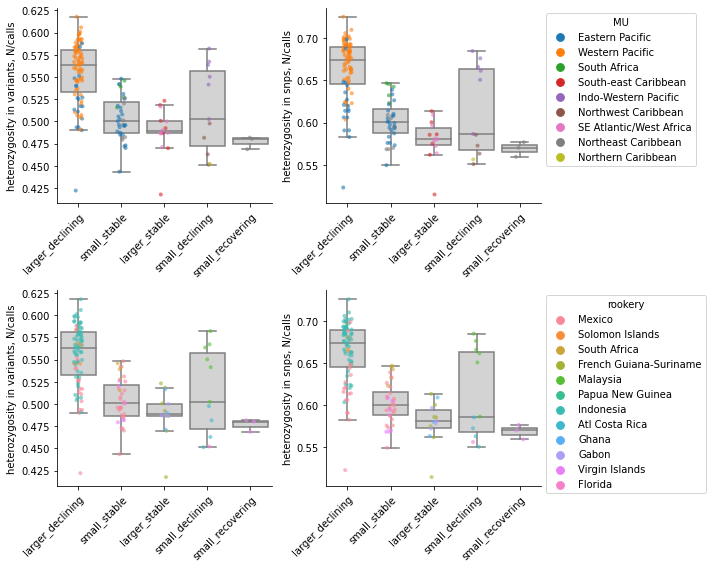

In [33]:
fig, axes = plt.subplots(2, 2, figsize = (10, 8))

groups = ['MU', 'rookery']
variants = set(df_all['variants'])

for j in range(len(groups)):
    for i, variant in enumerate(variants):
   
        axi = axes[j, i]
        dfi = df_all[df_all['variants'] == variant]
        dfi = dfi[dfi['exclude'] == 'include']
        group = groups[j]

        sns.boxplot(ax=axi, data=dfi, x='group', y='f_hets', showfliers=False, color="lightgrey")
        sns.stripplot(ax=axi, data=dfi, x='group', y='f_hets', hue=group, alpha=0.6, s=4)

        plt.setp(axi.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        axi.set_ylabel(f'heterozygosity in {variant}, N/calls')
        axi.set_xlabel('')

        if i != 1:
            axi.get_legend().set_visible(False)
        else:
            sns.move_legend(axi, "upper left", bbox_to_anchor=(1, 1))

sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False)
fig.tight_layout()

# pdf_name = 'total_number_variants_by_impact.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')